### ESMA 4016
### Regresion Logistica: La Curva ROC con scikit-learn y h2o
#### Edgar Acuna

In [155]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import h2o
from h2o.estimators.glm  import H2OGeneralizedLinearEstimator

h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,3 days 7 hours 16 mins
H2O cluster timezone:,America/La_Paz
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.6
H2O cluster version age:,"7 days, 19 hours and 36 minutes"
H2O cluster name:,H2O_from_python_edgar2017_7mwin8
H2O cluster total nodes:,1
H2O cluster free memory:,1.573 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


### I Regresion Logistica para Diabetes usando scikit learn

In [156]:
url= "http://academic.uprm.edu/eacuna/diabetes.dat"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_table(url, names=names,header=None)
#La variable de respuesta y debe ser binaria (0,1)
y=data['class']-1
X=data.iloc[:,0:8]
#Haciendo la regresion logistica ya calculando su precision
model = LogisticRegression()
model = model.fit(X, y)
print model.coef_

[[  1.17057358e-01   2.83881555e-02  -1.68873034e-02   7.55876596e-04
   -6.42924257e-04   5.97710296e-02   6.77534932e-01   7.24147639e-03]]


In [157]:
# Tasa de precision
model.score(X, y)
predictions = model.predict(X)
print(classification_report(y, predictions))

             precision    recall  f1-score   support

          0       0.79      0.90      0.84       500
          1       0.74      0.55      0.63       268

avg / total       0.77      0.77      0.77       768



### II. Curva ROC con scikit-learn

In [158]:
#Hallando las probabilidades posteriores
probs = model.predict_proba(X)
preds = probs[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y, preds)
roc_auc = auc(false_positive_rate, true_positive_rate)

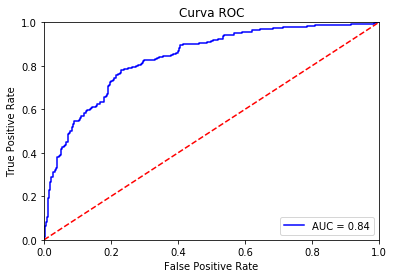

In [159]:
plt.title('Curva ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1.0])
plt.ylim([0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

El valor AUC representa el Area bajo la curva ROC (azul) oncerning the AUC. Una regla sencilla, dice que si el AUC de un clasificador va entre .9 y 1 entonces tiene una muy buena prediccion, entre .8 y .89 su prediciion es buena y menos de .60 de AUC es un pobre clasificador.


### Interseccion de las curvas de sensitividad y especificada par elegir el threshold

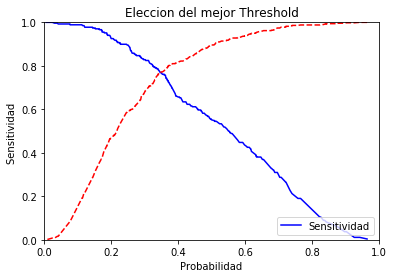

In [160]:
plt.title('Eleccion del mejor Threshold')
plt.plot(thresholds, true_positive_rate, 'b',label='Sensitividad')
plt.legend(loc='lower right')
plt.plot(thresholds, 1-false_positive_rate,'r--')
plt.xlim([0,1.0])
plt.ylim([0,1.0])
plt.ylabel('Sensitividad ')
plt.xlabel('Probabilidad')
plt.show()

El threshold que deberia ser usado en lugar de p=.5 para hacer la clasificacion sera aprox .35

### IV. Curva ROC en H20

In [161]:
diabetes = h2o.import_file("https://academic.uprm.edu/eacuna/diabetes.dat")
myx=['C1','C2','C3','C4','C5','C6','C7','C8']
diabetes['C9']=diabetes['C9'].asfactor()
myy='C9'
glm_model = H2OGeneralizedLinearEstimator(family= "binomial", lambda_ = 0, compute_p_values = True)
glm_model.train(myx, myy, training_frame= diabetes)
glm_model
glm_model._model_json['output']['coefficients_table']

Coefficients: glm coefficients



names,coefficients,std_error,z_value,p_value,standardized_coefficients
Intercept,-8.4046964,0.7166361,-11.7279840,0.0,-0.8711017
C1,0.1231823,0.0320776,3.8401399,0.0001230,0.4150724
C2,0.0351637,0.0037087,9.4813920,0.0,1.1242760
C3,-0.0132955,0.0052336,-2.5404157,0.0110721,-0.2573460
C4,0.0006190,0.0068994,0.0897131,0.9285152,0.0098739
C5,-0.0011917,0.0009012,-1.3223092,0.1860652,-0.1373362
C6,0.0897010,0.0150876,5.9453328,0.0000000,0.7072168
C7,0.9451797,0.2991475,3.1595776,0.0015800,0.3131651
C8,0.0148690,0.0093348,1.5928583,0.1111920,0.1748629


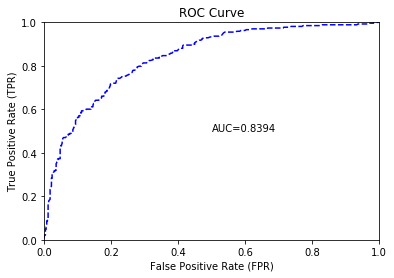

In [162]:
perf = glm_model.model_performance()  #train=True is the default, so it's not needed
perf.plot()